### SUPERVISED MACHINE LEARNING TO LEARN THE RELATIONSHIP BETWEEN CLUSTERS AND FEATURES

In [1]:
# SUPERVISED MACHINE LEARNING 
# increase the clarity of plots
%config InlineBackend.figure_format='retina'

In [2]:
# import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# import sklearn models
from sklearn.linear_model import LogisticRegression # 1
from sklearn.neighbors import KNeighborsClassifier # 2
from sklearn.ensemble import RandomForestClassifier # 3
from xgboost import XGBClassifier # 4

# preview data
df = pd.read_csv("https://raw.githubusercontent.com/rmratliffbrown/ml-genre-assignment/main/10_clustering/kmeans_cluster.csv").iloc[:,1:]
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,label
0,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,4
1,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,4
2,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,4
3,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,3
4,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,4


In [3]:
# check the number of observations in each cluster
df.label.value_counts()

4    11683
3     9093
2     4889
1     4600
0     2568
Name: label, dtype: int64

In [4]:
# define feature variable
X = df.drop("label", axis=1)
X.sample(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
19223,0.783,0.748,8,-4.683,1,0.0892,0.1470,0.000000,0.1730,0.806,93.222,182747
3293,0.619,0.631,9,-7.014,0,0.0280,0.0211,0.000006,0.2060,0.443,121.000,193293
18214,0.747,0.649,10,-6.218,0,0.2190,0.3330,0.000000,0.1720,0.840,88.011,200733
215,0.517,0.793,6,-5.851,0,0.0367,0.0214,0.000460,0.0892,0.176,90.060,157333
30713,0.536,0.782,7,-4.139,0,0.0485,0.0390,0.000036,0.0691,0.405,154.930,204778


In [5]:
# define label variable
y = np.array(df["label"])
y

array([4, 4, 4, ..., 3, 3, 3])

In [6]:
# SPLIT DATA INTO TRAIN AND VALIDATION DATA(80:20)TO GAIN A CURSORY UNDERSTANDING OF HOW OUR
# CHOSEN MODELS WOULD PERFORM ON UNSEEN DATA BEFORE SPLITTING THE DATA AS SHOWN IN THE EXPERIMENT
# DESIGN AND CARRYING OUT HYPERPARAMETER TUNING ON A SUB-SAMPLE OF THE DATA

# split entire data set to train and validation data set to gain a cursory understanding of how well a model
# train on 80% of the data would generalize
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

### 1. Logistic Regression - Baseline Model

In [7]:
# 1. LOGISTIC REGRESSION
# create pipeline for logistic regression that standardizes feature space before running 
# a logistic classifier with baseline parameters
pipeline_lr = Pipeline(
    [
        ("scalar1", StandardScaler()),
        ("lr_clf", LogisticRegression(solver='saga',random_state=0,multi_class='multinomial',max_iter=1000,tol=10e-3)),
    ]
)

In [8]:
# evaluate performance on validation data
pipeline_lr.fit(X_train, y_train)
# make prediction on validation data
y_val_pred = pipeline_lr.predict(X_val)
# check first 20 ground truths and prediction
print('Actual label:    ', y_val[:20])
print('Predicted label: ', y_val_pred[:20])

Actual label:     [3 1 0 4 3 0 4 3 4 1 2 3 4 1 4 3 3 3 0 3]
Predicted label:  [3 1 0 4 3 0 4 3 4 1 2 3 4 1 4 3 3 4 0 3]


In [9]:
# module for classification report
from sklearn.metrics import classification_report
# print out classification report
target_names = ['cluster 0', 'cluster 1', 'cluster 2','cluster 3', 'cluster 4']
print(classification_report(y_val, y_val_pred, target_names=target_names))


              precision    recall  f1-score   support

   cluster 0       0.97      0.99      0.98       497
   cluster 1       1.00      0.99      1.00       903
   cluster 2       0.99      0.99      0.99       995
   cluster 3       0.99      0.99      0.99      1841
   cluster 4       0.99      0.99      0.99      2331

    accuracy                           0.99      6567
   macro avg       0.99      0.99      0.99      6567
weighted avg       0.99      0.99      0.99      6567



In [10]:
# After standardizing the feature space and training a our baseline logistic regression model on 80% of the data we see that our baseline model with initial hyperparamters
# ('saga' solver, 1000 maximum iterations and 10e-3 tolerance) achieves a near perfect score on all relevant metrics. Even though our experiment stated the we would do 
# hyperparameter tuning on a subsample, these results prevents us from doing so. Nevertheless, we proceed to investigate how random forest and XGBoost performns on the 
# validation data.

In [11]:
# classification report
report_1 = classification_report(y_val, y_val_pred, target_names=target_names,output_dict=True)
df_r_logistic = pd.DataFrame(report_1).transpose()
df_r_logistic.head()

,precision,recall,f1-score,support
cluster 0,0.970297,0.985915,0.978044,497.0
cluster 1,0.997775,0.993355,0.995560,903.0
cluster 2,0.987915,0.985930,0.986922,995.0
cluster 3,0.994005,0.990766,0.992383,1841.0
cluster 4,0.992719,0.994423,0.993571,2331.0


In [12]:
df_r_logistic.to_latex("~/Downloads/logistic.tex")

<Figure size 1440x864 with 0 Axes>

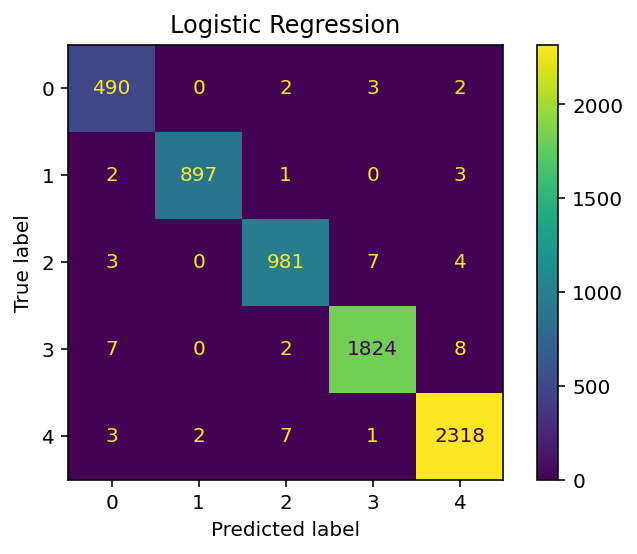

In [13]:
# import module for confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# plot confusion matrix of logistic regression
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic Regression")
plt.show()

In [14]:
# AUC
y_val_proba = pipeline_lr.predict_proba(X_val)

# roc auc score using one versus rest and macro average
LR_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='macro')
f"The average AUC for the logistic regression model is {LR_auc:0.3f}"

'The average AUC for the logistic regression model is 1.000'

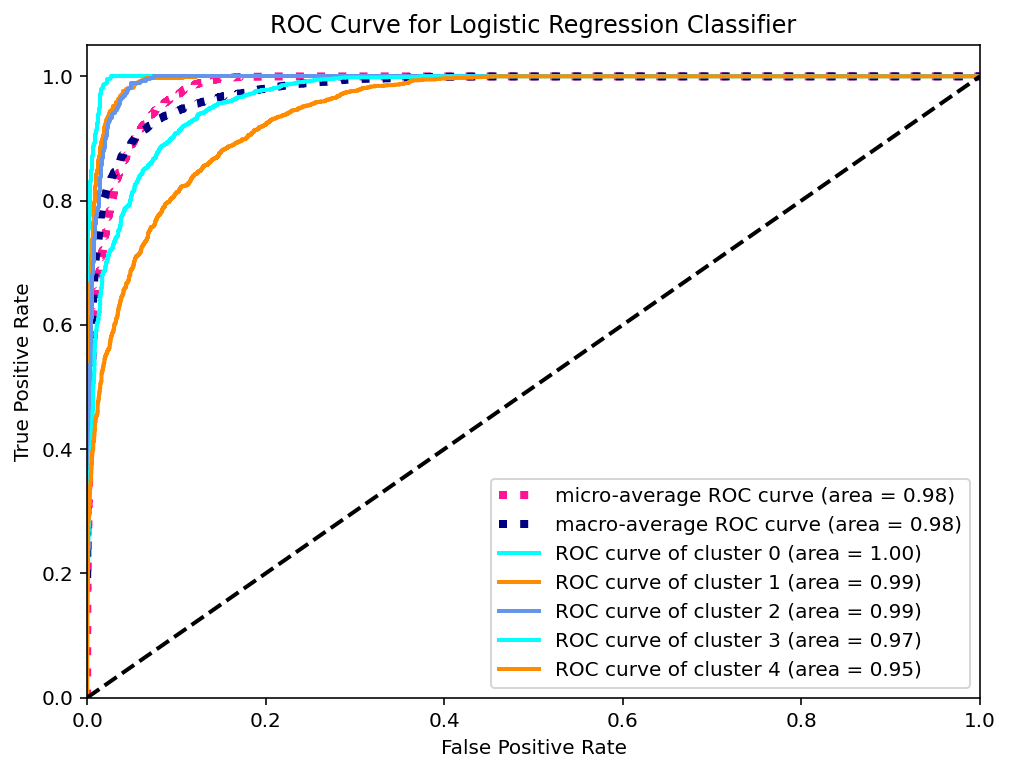

In [15]:
# Plot ROC Curves for Logistic Regression
from sklearn.preprocessing import label_binarize
from itertools import cycle
y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3, 4])

n_classes = 5
lw=2

y_score = pipeline_lr.decision_function(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot ROC for a specific class
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of cluster {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression Classifier")
plt.legend(loc="lower right")
plt.show()

In [16]:
# f1 score
from sklearn.metrics import f1_score
LR_f1 = f1_score(y_val, y_val_pred, average='macro')
f"The baseline F1(macro) socre of the logistic regression model on the validation data is {LR_f1:0.3f}"

'The baseline F1(macro) socre of the logistic regression model on the validation data is 0.989'

### 2. Random Forest

In [17]:
# 2. RANDOM FOREST
# instantiate a class for random forest classifier
rf_clf = RandomForestClassifier(random_state=0)

In [18]:
rf_clf.fit(X_train, y_train)
# make prediction on validation data
y_val_pred = rf_clf.predict(X_val)
# check first 20 ground truths and prediction
print('Actual label:    ', y_val[:20])
print('Predicted label: ', y_val_pred[:20])

Actual label:     [3 1 0 4 3 0 4 3 4 1 2 3 4 1 4 3 3 3 0 3]
Predicted label:  [3 1 0 4 3 0 4 3 4 1 2 3 4 1 4 3 3 4 0 3]


In [19]:
# print classification report
target_names = ['cluster 0', 'cluster 1', 'cluster 2','cluster 3', 'cluster 4']
print(classification_report(y_val, y_val_pred, target_names=target_names))

              precision    recall  f1-score   support

   cluster 0       0.96      0.97      0.97       497
   cluster 1       0.95      0.97      0.96       903
   cluster 2       0.95      0.94      0.95       995
   cluster 3       0.97      0.96      0.96      1841
   cluster 4       0.96      0.96      0.96      2331

    accuracy                           0.96      6567
   macro avg       0.96      0.96      0.96      6567
weighted avg       0.96      0.96      0.96      6567



In [20]:
# classification report
report_2 = classification_report(y_val, y_val_pred, target_names=target_names,output_dict=True)
df_r_rf = pd.DataFrame(report_2).transpose()
df_r_rf.head()

,precision,recall,f1-score,support
cluster 0,0.964000,0.969819,0.966901,497.0
cluster 1,0.953210,0.970100,0.961581,903.0
cluster 2,0.950455,0.944724,0.947581,995.0
cluster 3,0.966046,0.958175,0.962094,1841.0
cluster 4,0.962709,0.963535,0.963122,2331.0


In [21]:
# save classification report to latex table
df_r_rf.to_latex("~/Downloads/rand_forest.tex")

<Figure size 1440x864 with 0 Axes>

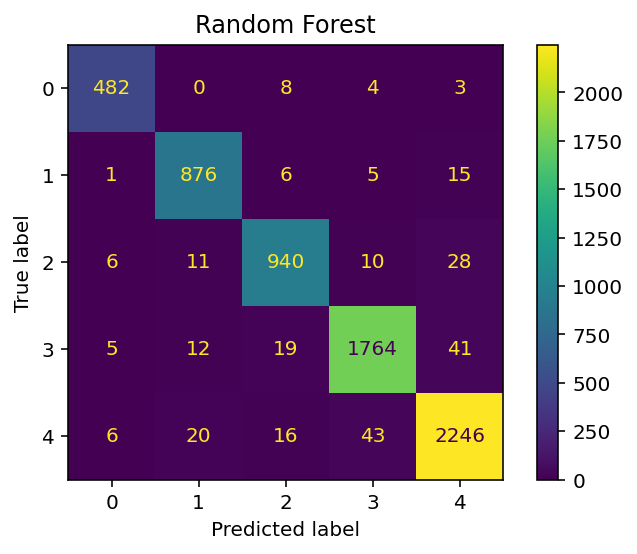

In [22]:
# plot confusion matrix of random forest model
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Random Forest")
plt.show()

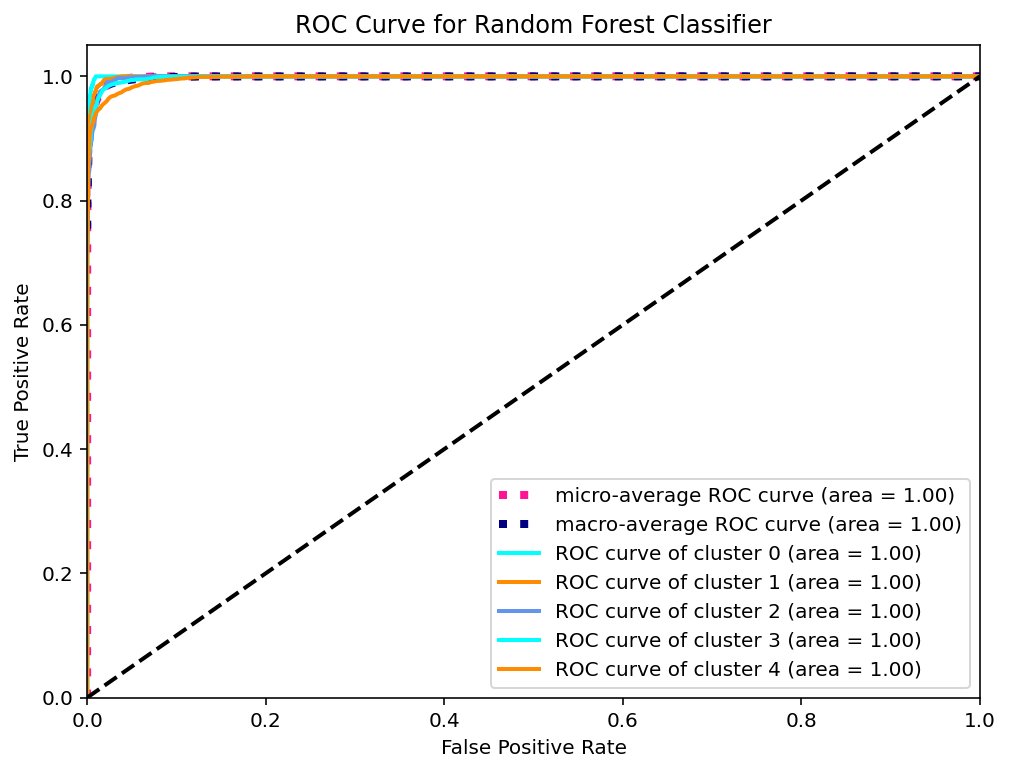

In [23]:
# Plot ROC for Random Forest Classifier
y_score = rf_clf.predict_proba(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot ROC for a specific class
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of cluster {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest Classifier")
plt.legend(loc="lower right")
plt.show()

In [24]:
RF_f1 = f1_score(y_val, y_val_pred, average='macro')
f"The F1(macro) socre of the random forest model on the validation data is {RF_f1:0.3f}"

'The F1(macro) socre of the random forest model on the validation data is 0.960'

### XGBoost

In [25]:
xg_clf = XGBClassifier(booster='gbtree', use_label_encoder=False, eval_metric='mlogloss')

In [26]:
xg_clf.fit(X_train, y_train)
# make prediction on validation data
y_val_pred = rf_clf.predict(X_val)
# check first 20 ground truths and prediction
print('Actual label:    ', y_val[:20])
print('Predicted label: ', y_val_pred[:20])

Actual label:     [3 1 0 4 3 0 4 3 4 1 2 3 4 1 4 3 3 3 0 3]
Predicted label:  [3 1 0 4 3 0 4 3 4 1 2 3 4 1 4 3 3 4 0 3]


In [27]:
# print classification report
target_names = ['cluster 0', 'cluster 1', 'cluster 2','cluster 3', 'cluster 4']
print(classification_report(y_val, y_val_pred, target_names=target_names))

              precision    recall  f1-score   support

   cluster 0       0.96      0.97      0.97       497
   cluster 1       0.95      0.97      0.96       903
   cluster 2       0.95      0.94      0.95       995
   cluster 3       0.97      0.96      0.96      1841
   cluster 4       0.96      0.96      0.96      2331

    accuracy                           0.96      6567
   macro avg       0.96      0.96      0.96      6567
weighted avg       0.96      0.96      0.96      6567



In [28]:
report_3 = classification_report(y_val, y_val_pred, target_names=target_names,output_dict=True)
df_r_xgb = pd.DataFrame(report_3).transpose()
df_r_xgb.head()

,precision,recall,f1-score,support
cluster 0,0.964000,0.969819,0.966901,497.0
cluster 1,0.953210,0.970100,0.961581,903.0
cluster 2,0.950455,0.944724,0.947581,995.0
cluster 3,0.966046,0.958175,0.962094,1841.0
cluster 4,0.962709,0.963535,0.963122,2331.0


In [29]:
# save classification report to latex table
df_r_xgb.to_latex("~/Downloads/xgboost.tex")

<Figure size 1440x864 with 0 Axes>

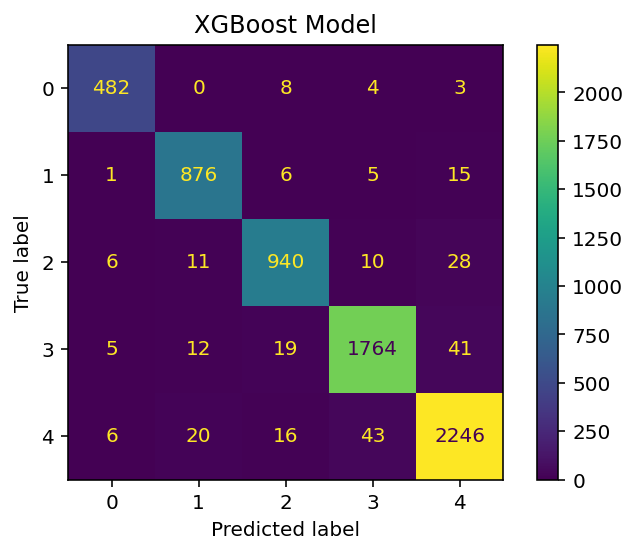

In [30]:
# plot confusion matrix of XGBoost model
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("XGBoost Model")
plt.show()

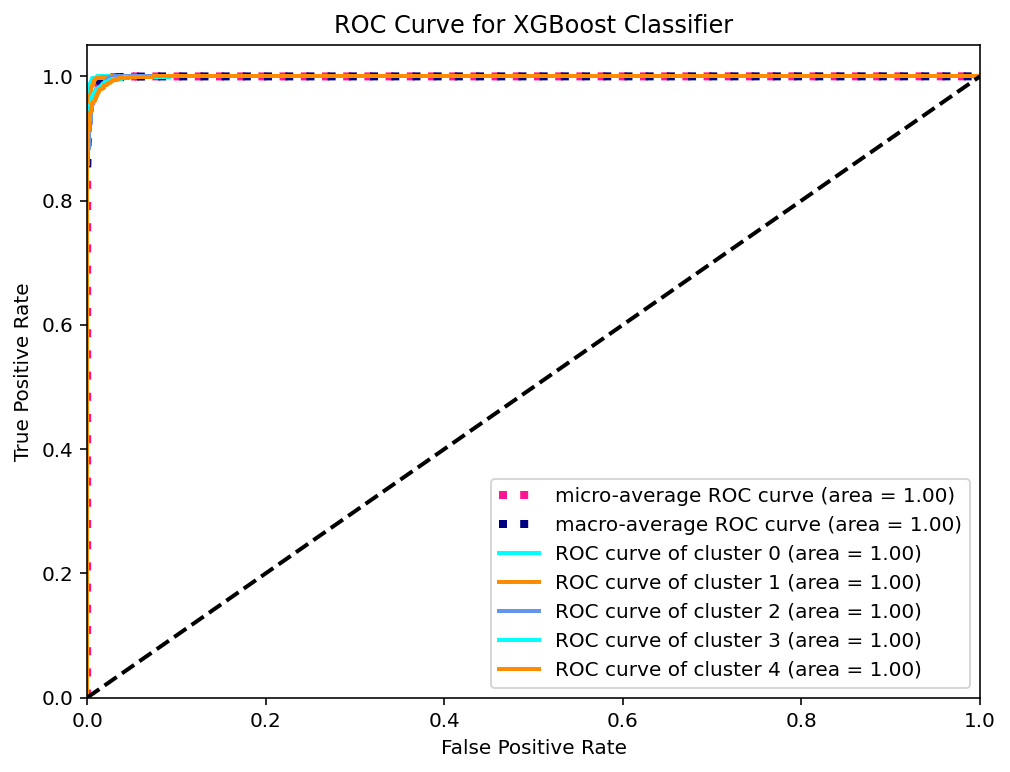

In [34]:
# Plot ROC for Random Forest Classifier
y_score = xg_clf.predict_proba(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot ROC for a specific class
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of cluster {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Classifier")
plt.legend(loc="lower right")
plt.show()

In [32]:
XG_f1 = f1_score(y_val, y_val_pred, average='macro')
f"The F1(macro) socre of the XGBoost model on the validation data is {XG_f1:0.3f}"

'The F1(macro) socre of the XGBoost model on the validation data is 0.960'